<a href="https://colab.research.google.com/github/AlonVery/ready_to_start_NL/blob/main/NL_tree_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Основной вариант модели для проекта

## Загрузка, обработка, удаление дубликатов,

In [ ]:
!pip install scapy
!pip install mocket
!pip install xgboost

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import IsolationForest
from sklearn.compose import ColumnTransformer
from tensorflow.keras.metrics import Accuracy
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from scapy.all import *


In [ ]:
# вытаскиваем тренировачный датасет и разбиваем каждую колонку на нужный нам параметр всего 43
#выделяем каждый датасет отдельно на тест и на треин
#df.head() #df.info() #df['protocol_type'].unique()
#data = df.drop('attack', axis=1)
#df.head()

columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

df_train=pd.read_csv('https://raw.githubusercontent.com/stepka123/basic-NL-SA/stepka123-KDD_Dataset/KDDTrain%2B.txt',header=None,names=columns)
df_test=pd.read_csv('https://raw.githubusercontent.com/stepka123/basic-NL-SA/stepka123-KDD_Dataset/KDDTest%2B.txt',header=None,names=columns)
df = pd.concat([df_train, df_test])
df_train.head()

In [ ]:
#чистим будущие данные от NaN/ Null values

def clean_dataset(df_test):
    assert isinstance(df_test, pd.DataFrame), "df_test needs to be a pd.DataFrame"
    df_test.dropna(inplace=True)
    indices_to_keep = ~df_test.isin([np.nan, np.inf, -np.inf]).any(1)
    return data_test[indices_to_keep]

def clean_dataset(df_train):
    assert isinstance(df_train, pd.DataFrame), "df_train needs to be a pd.DataFrame"
    df_train.dropna(inplace=True)
    indices_to_keep = ~df_train.isin([np.nan, np.inf, -np.inf]).any(1)
    return df_train[indices_to_keep]


In [ ]:
#Дропаем дубликаты
df_dpl = df.duplicated().sum()
print("Дубликаты: ",df_dpl)
df.drop_duplicates(inplace=True)

Дубликаты:  0


In [ ]:
# changing attack labels to their respective attack class
def change_label(df):
    df.attack.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
    df.attack.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
    df.attack.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
    df.attack.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

le1 = LabelEncoder()
le2 = LabelEncoder()
le3 = LabelEncoder()
le4 = LabelEncoder()

le_protocol_type = le1.fit(df['protocol_type'])
le_service = le2.fit(df['service'])
le_flag = le3.fit(df['flag'])

le_attack = le4.fit(df['attack'])
df['protocol_type'] = le_protocol_type.transform(df['protocol_type'])
df['service'] = le_service.transform(df['service'])
df['flag'] = le_flag.transform(df['flag'])

df['attack'] = le_attack.transform(df['attack'])

#Здесь же код который я беру на тест с kagele и на данный момент является основной моделью
Автоенкодер который будет оринтироваться по слассу атак, а именно разметит сам зависимости, разобьет эти зависимости на классы и будт обучатьс яуже относительно них.


### Разметка обучающего и тестового датасета

In [ ]:
from sklearn.model_selection import train_test_split
y_train= df[['attack']]
X_train= df.drop(labels=['attack'], axis=1)

print('X_train has shape:',X_train.shape,'\ny_train has shape:',y_train.shape)

X_train has shape: (147907, 42) 
y_train has shape: (147907, 1)


In [ ]:
# splitting the dataset 80% for training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size=0.20, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

In [ ]:
target_names = ['normal', 'Dos', 'Probe', 'R2L', 'U2R']

### Байсет с гауссовскими признаками

In [ ]:
# Создание экземпляра классификатора наивного Байеса с гауссовскими признаками
gnb = GaussianNB()

# Обучение классификатора на обучающих данных
gnb = gnb.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
gnb_pred = gnb.predict(X_test)  # Предсказание меток классов на тестовом наборе
gnb_pred
gnb_acc = accuracy_score(y_test, gnb_pred)  # Вычисление точности предсказаний
gnb_acc

0.3658305726455277

In [ ]:
gnb_cm = confusion_matrix(y_test, gnb_pred)

### Байсет Decision Tree

In [ ]:
#Decision Tree
dt = DecisionTreeClassifier()  # Создание модели дерева принятия решений
dt = dt.fit(X_train, y_train)  # Обучение модели на обучающем наборе данных

In [ ]:
dt_pred = dt.predict(X_test)
dt_pred

array([16, 27, 16, ..., 15, 14, 16])

In [ ]:
dt_acc = accuracy_score(y_test, dt_pred)
dt_acc

0.9954364140355622

In [ ]:
dt_cm = confusion_matrix(y_test, dt_pred)

### Байсет Random Forest

In [ ]:
#Random Forest
rf = RandomForestClassifier()
rf = rf.fit(X_train, y_train)

NameError: name 'RandomForestClassifier' is not defined

In [ ]:
rf_pred = rf.predict(X_test)
rf_pred


In [ ]:
rf_acc = accuracy_score(y_test, rf_pred)
rf_acc

In [ ]:
rf_cm = confusion_matrix(y_test, rf_pred)

### Байсет CatBoost

In [ ]:
#Катбуст
cb = CatBoostClassifier()
cb = cb.fit(X_train, y_train)

In [ ]:
cb_pred = cb.predict(X_test)
cb_pred

array([[16],
       [27],
       [16],
       ...,
       [15],
       [14],
       [16]])

In [ ]:
cb_acc = accuracy_score(y_test, cb_pred)
cb_acc

0.9972956527618146

In [ ]:
cb_cm = confusion_matrix(y_test, cb_pred)

### Сравнительные таблицы


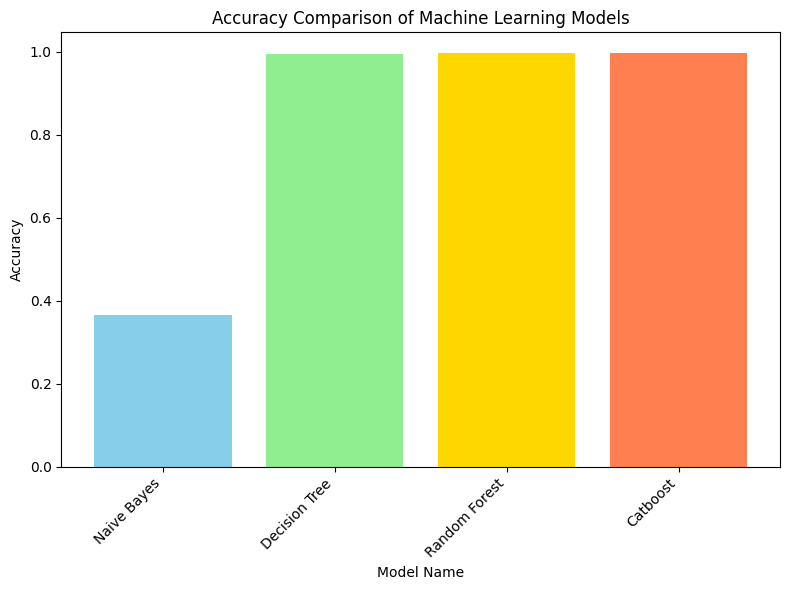

In [ ]:
import seaborn as sns
models = ['Naive Bayes', 'Decision Tree', 'Random Forest', 'Catboost']
accuracies = [gnb_acc, dt_acc, rf_acc, cb_acc]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'gold', 'coral', 'violet'])
plt.xlabel('Model Name')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Machine Learning Models')
plt.xticks(rotation=45, ha='right')


# Display the bar chart
plt.tight_layout()
plt.show()

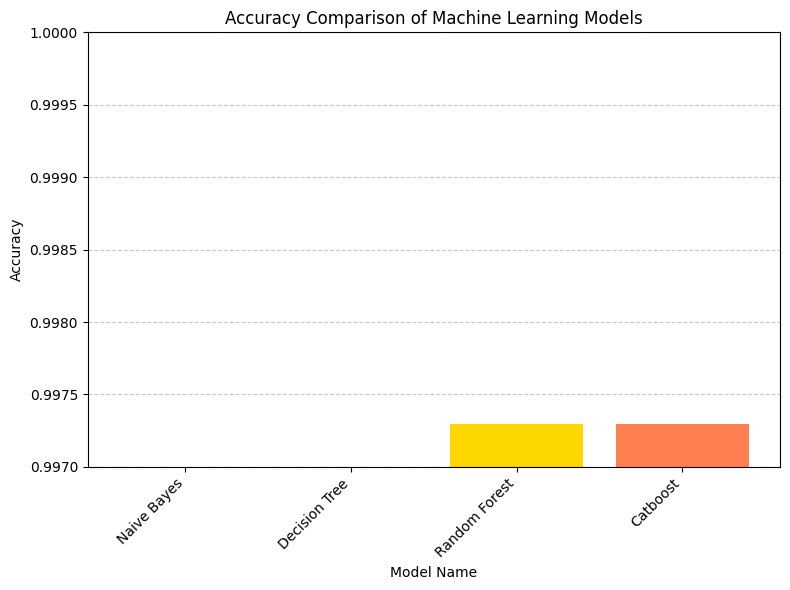

In [ ]:
models = ['Naive Bayes', 'Decision Tree', 'Random Forest', 'Catboost']
accuracies = [gnb_acc, dt_acc, rf_acc, cb_acc]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'gold', 'coral', 'violet'])
plt.xlabel('Model Name')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Machine Learning Models')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set y-axis limits to focus on the narrow range
plt.ylim(0.997, 1.00)

# Display the bar chart
plt.tight_layout()
plt.show()

In [ ]:
#оценка потерь и лузов
def false_alarm_rate(cm):
    true_normal = cm[0,0]
    false_attack = cm[0,1] + cm[0,2] + cm[0,3] + cm[0,4]

    return false_attack/(true_normal + false_attack)


In [ ]:
gnb_far = false_alarm_rate(gnb_cm)
dt_far = false_alarm_rate(dt_cm)
rf_far = false_alarm_rate(rf_cm)
cb_far = false_alarm_rate(cb_cm)

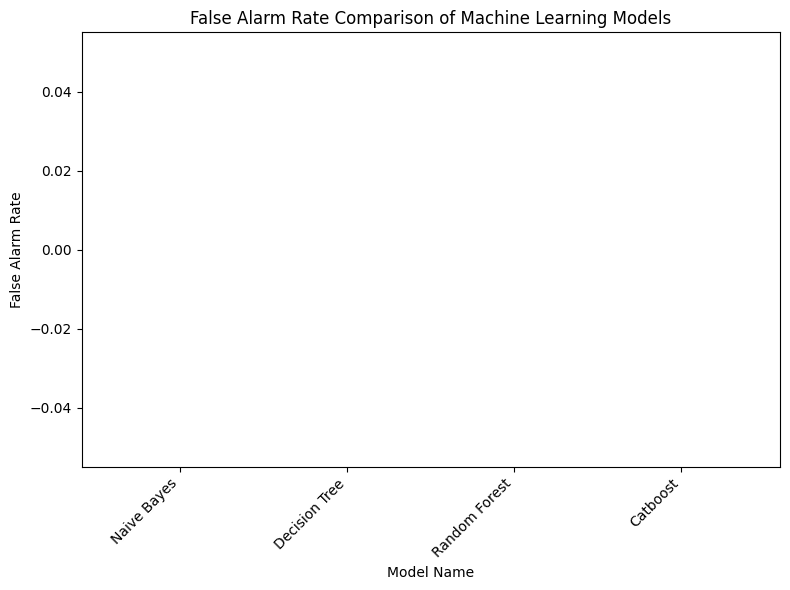

In [ ]:
models = ['Naive Bayes', 'Decision Tree', 'Random Forest', 'Catboost']
accuracies = [gnb_far, dt_far, rf_far, cb_far]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'gold', 'coral', 'violet'])
plt.xlabel('Model Name')
plt.ylabel('False Alarm Rate')
plt.title('False Alarm Rate Comparison of Machine Learning Models')
plt.xticks(rotation=45, ha='right')


# Display the bar chart
plt.tight_layout()
plt.show()

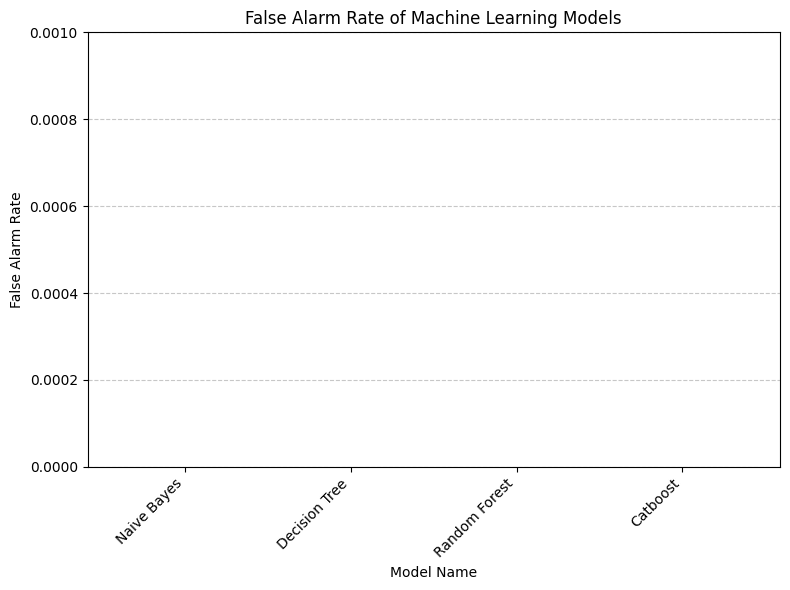

In [ ]:
models = ['Naive Bayes', 'Decision Tree', 'Random Forest', 'Catboost']
accuracies = [gnb_far, dt_far, rf_far, cb_far]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'gold', 'coral', 'violet'])
plt.xlabel('Model Name')
plt.ylabel('False Alarm Rate')
plt.title('False Alarm Rate of Machine Learning Models')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set y-axis limits to focus on the narrow range
plt.ylim(0, 0.001)

# Display the bar chart
plt.tight_layout()
plt.show()

### Сохранение и попытка практического применения в поиске аномалий

In [ ]:
#Save Best Model
import pickle
from joblib import dump, load
import socket
from scapy.all import sniff
from unittest.mock import patch
import random

In [ ]:
filename = 'best_model.sav'
pickle.dump(xg, open(filename, 'wb'))

In [ ]:
df_test = pd.read_csv('https://raw.githubusercontent.com/stepka123/basic-NL-SA/stepka123-KDD_Dataset/KDDTest-21.txt')

columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate'
,'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','attack','level'])

df_test.columns = columns
df_test

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,udp,private,SF,44,0,0,0,0,0,...,1.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,snmpguess,12
1,0,tcp,telnet,S3,0,44,0,0,0,0,...,0.31,0.61,0.00,0.00,0.21,0.68,0.60,0.00,processtable,18
2,0,udp,private,SF,53,55,0,0,0,0,...,1.00,0.00,0.87,0.00,0.00,0.00,0.00,0.00,normal,17
3,0,tcp,private,SH,0,0,0,0,0,0,...,0.06,1.00,1.00,0.00,1.00,1.00,0.00,0.00,nmap,17
4,0,tcp,http,SF,54540,8314,0,0,0,2,...,0.90,0.01,0.00,0.00,0.00,0.00,0.01,0.00,back,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11844,0,udp,domain_u,SF,43,43,0,0,0,0,...,1.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,normal,18
11845,0,tcp,http,SF,336,285,0,0,0,0,...,0.92,0.02,0.00,0.00,0.00,0.00,0.05,0.00,normal,18
11846,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.37,0.03,0.01,0.02,0.05,0.08,0.85,0.58,mscan,13
11847,0,tcp,sunrpc,REJ,0,0,0,0,0,0,...,0.19,0.03,0.01,0.04,0.00,0.00,0.88,1.00,mscan,15


In [ ]:
df_test = df_test.drop(['attack', 'level'], axis=1)
loaded_model = pickle.load(open(filename, 'rb'))


In [ ]:
def intrusion_check(packet):
    packet[1] = le_protocol_type.transform([packet[1]])[0]
    packet[2] = le_service.transform([packet[2]])[0]
    packet[3] = le_flag.transform([packet[3]])[0]
    pred = loaded_model.predict(np.reshape(packet, (1, 41)))
    predicted = le_attack.inverse_transform(pred)

    return predicted[0]

In [ ]:
from scapy.all import *
def capture_packet(count):
    filtered_packets = []

    def handle_sniffed_packet(packet):
        num = random.randint(0, 11849)
        check = intrusion_check(list(df_test.iloc[num]))
        if check == 'normal':
            filtered_packets.append(packet)
            print(f'Packet Safe, From [{packet.src}] To [{packet.dst}]')
        else:
            print(f'Caution! Found {check}, From [{packet.src}] To [{packet.dst}]')

    # Start capturing packets using sniff
    process_packet(packet)

    return filtered_packets



In [ ]:
from scapy.all import *
def process_packet(packet):
    data = ""

    if IP in packet:
        src_ip = packet[IP].src
        dst_ip = packet[IP].dst

        # Определяем количество байт в каждом направлении
        if TCP in packet:
            bytes_sent = len(packet[TCP].payload)
            bytes_received = packet[IP].len - bytes_sent
            proto = "tcp"
        elif UDP in packet:
            bytes_sent = len(packet[UDP].payload)
            bytes_received = packet[IP].len - bytes_sent
            proto = "udp"
        elif ICMP in packet:
            bytes_sent = len(packet[ICMP].payload)
            bytes_received = packet[IP].len - bytes_sent
            proto = "icmp"
        else:
            bytes_sent = 0
            bytes_received = 0
            proto = "other"

        # Определяем специфичные протоколы
        if proto == "tcp":
            if packet[TCP].dport == 22:
                proto = "ssh"
            elif packet[TCP].dport == 23:
                proto = "telnet"
            elif packet[TCP].dport == 25:
                proto = "smtp"
            elif packet[TCP].dport == 110:
                proto = "pop3"
        elif proto == "udp":
            if packet[UDP].dport == 67 or packet[UDP].dport == 68:
                proto = "dhcp"
            # Добавьте другие протоколы, если необходимо

        data += f"0,{proto},"  # Добавляем IP протокол и нулевое значение для первого элемента
        data += f"{src_ip},{dst_ip},"     # Добавляем IP адреса отправителя и получателя
        data += f"{bytes_sent},{bytes_received},"  # Добавляем количество байт в каждом направлении

        # Добавляем остальные параметры
        data += ",".join(map(str, packet[IP].payload.fields.values()))

        print(data)

# Захватываем и обрабатываем сетевой трафик
        sniff(prn=process_packet, store=0)  # store=0 для обработки пакетов в реальном времени


In [ ]:
packets = capture_packet(20)

###Ниже код который нужно будет делать самому и под себя

In [ ]:
#преобразовываем данные в читабельном виде для нс
#protocol_type, service, flag,


In [ ]:
#url = '/content/KDDTrain+.txt'
#df = pd.read_csv("/content/KDDTrain+.txt")
#df.to_csv('KDDTrain+.txt', index=False)
#df.info()

In [ ]:
df['attack'].unique()
# changing attack labels to their respective attack class
def change_label_attack(df):
    df.attack.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
    df.attack.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
    df.attack.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
    df.attack.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

df.Label.value_counts()


change_lable_proto(df)
df.head()

AttributeError: 'DataFrame' object has no attribute 'Label'

Эксперименты c графиками

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
plt.plot(df['protocol_type'], df['attack'], '+')
plt.xlabel('105')
plt.ylabel('normal.')
plt.title('Plot of signal distribution over time')
plt.grid(True)

In [ ]:
plt.subplot(121)
plt.plot(df['No.'], df['Length'], 'o')
plt.grid(True)

plt.subplot(122)
plt.plot(df.head(100)['No.'], df.head(100)['Protocol'])
plt.grid(True)
plt.show()

Source	Destination	Protocol Length